# FSDP Overlap Analysis: A Unified Theory

## Core Insight

The critical batch size for FSDP overlap can be decomposed into two independent factors:

$$B_{crit} = \frac{\eta}{\rho}$$

Where:
- **$\rho$ (Compute Density)** = FLOPs_per_token / Params — *model-intrinsic property*
- **$\eta$ (Hardware Factor)** = TFLOPS × bytes / BW — *hardware-intrinsic property*

---

## Definition 1: Compute Density ($\rho$)

$$\rho = \frac{\text{FLOPs}_{\text{per token}}}{\text{Params}}$$

| Component | Formula | Typical Value |
|-----------|---------|---------------|
| Dense MatMul | 2 (per matmul) | ~6 (3 matmuls in FFN) |
| MoE FFN | 6 × k/E | 6 × 8/256 = 0.19 |
| Attention | f(seq_len) | Grows with S |

**Key insight:** MoE's sparsity creates a ~20x density gap vs dense layers!

### Why Forward-Only Analysis Suffices

In training, backward pass has ~2× the compute and ~2× the communication of forward:
- **Compute**: bwd needs $\frac{\partial L}{\partial W}$ (weight grad) + $\frac{\partial L}{\partial X}$ (activation grad)
- **Communication**: bwd has reduce-scatter (gradients) in addition to all-gather

Since both scale by the same factor, $B_{crit}$ remains unchanged:

$$\frac{T_{compute}^{bwd}}{T_{comm}^{bwd}} = \frac{2 \times T_{compute}^{fwd}}{2 \times T_{comm}^{fwd}} = \frac{T_{compute}^{fwd}}{T_{comm}^{fwd}} = B_{crit}$$

**Therefore, we analyze forward pass only.**

---

## Definition 2: Hardware Factor ($\eta$)

$$\eta = \frac{\text{TFLOPS} \times \text{bytes\_per\_elem}}{\text{BW}}$$

- Higher η = more compute per byte of communication
- Lower η = easier to achieve overlap

---

## Definition 3: Critical Batch Size ($B_{crit}$)

$$B_{crit} = \frac{\eta}{\rho} = \frac{\text{TFLOPS} \times \text{bytes}}{\text{BW}} \times \frac{\text{Params}}{\text{FLOPs}_{\text{per token}}}$$

The minimum batch size where compute time equals communication time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict

In [2]:
# =============================================================================
# CORE DEFINITIONS
# =============================================================================

DTYPE_BYTES = {"bf16": 2, "fp8": 1, "fp4": 0.5}


@dataclass
class GPU:
    """GPU specifications with compute and bandwidth."""
    name: str
    tflops: Dict[str, float]  # dtype -> TFLOPS
    nvlink_gbps: float        # intra-node GPU-GPU (unidirectional)
    ib_gbps: float            # inter-node aggregate per node
    hbm_gb: int = 80
    
    @property
    def bw_gbps(self) -> float:
        """Effective bandwidth: min(NVLink, IB) for multi-node."""
        return min(self.nvlink_gbps, self.ib_gbps)
    
    def hw_factor(self, dtype: str) -> float:
        """
        Hardware factor: eta = TFLOPS * bytes / BW
        Unit: dimensionless ratio
        """
        if dtype not in self.tflops:
            raise ValueError(f"{dtype} not supported on {self.name}")
        bytes_per_elem = DTYPE_BYTES[dtype]
        return (self.tflops[dtype] * 1e12 * bytes_per_elem) / (self.bw_gbps * 1e9)


def bcrit(density: float, hw_factor: float) -> float:
    """
    Critical batch size: B_crit = eta / rho
    
    Args:
        density: FLOPs/Param (rho)
        hw_factor: TFLOPS * bytes / BW (eta)
    
    Returns:
        Minimum batch size for full compute/comm overlap
    """
    return hw_factor / density


print("Core Definitions:")
print("  rho (density)   = FLOPs / Params       [model property]")
print("  eta (hw_factor) = TFLOPS * bytes / BW  [hardware property]")
print("  BW              = min(NVLink, IB)      [multi-node bottleneck]")
print("  B_crit          = eta / rho            [result]")

Core Definitions:
  rho (density)   = FLOPs / Params       [model property]
  eta (hw_factor) = TFLOPS * bytes / BW  [hardware property]
  BW              = min(NVLink, IB)      [multi-node bottleneck]
  B_crit          = eta / rho            [result]


In [3]:
# =============================================================================
# GPU SPECIFICATIONS
# =============================================================================

GPUS = {
    "A100": GPU(
        name="A100 (Ampere)",
        tflops={"bf16": 312},
        nvlink_gbps=300,
        ib_gbps=200,
        hbm_gb=80,
    ),
    "H200": GPU(
        name="H200 (Hopper)",
        tflops={"bf16": 989, "fp8": 1979},
        nvlink_gbps=450,
        ib_gbps=400,
        hbm_gb=141,
    ),
    "B300": GPU(
        name="B300 (Blackwell)",
        tflops={"bf16": 2250, "fp8": 4500, "fp4": 9000},
        nvlink_gbps=900,
        ib_gbps=800,
        hbm_gb=268,
    ),
    "Rubin": GPU(
        name="Rubin",
        tflops={"bf16": 4500, "fp8": 9000, "fp4": 18000},
        nvlink_gbps=1800,
        ib_gbps=800,
        hbm_gb=288,
    ),
}


# Print GPU specs
print("GPU Specifications")
print("=" * 85)
print(f"{'GPU':<8} {'BF16':>10} {'FP8':>10} {'FP4':>10} {'NVLink':>10} {'IB':>10} {'BW_eff':>10} {'HBM':>8}")
print(f"{'':8} {'TFLOPS':>10} {'TFLOPS':>10} {'TFLOPS':>10} {'GB/s':>10} {'GB/s':>10} {'GB/s':>10} {'GB':>8}")
print("-" * 85)
for name, gpu in GPUS.items():
    bf16 = f"{gpu.tflops.get('bf16', 0):.0f}"
    fp8 = f"{gpu.tflops.get('fp8', 0):.0f}" if 'fp8' in gpu.tflops else "N/A"
    fp4 = f"{gpu.tflops.get('fp4', 0):.0f}" if 'fp4' in gpu.tflops else "N/A"
    print(f"{name:<8} {bf16:>10} {fp8:>10} {fp4:>10} {gpu.nvlink_gbps:>10.0f} {gpu.ib_gbps:>10.0f} {gpu.bw_gbps:>10.0f} {gpu.hbm_gb:>8}")
print()
print("BW_eff = min(NVLink, IB) for multi-node training")

GPU Specifications
GPU            BF16        FP8        FP4     NVLink         IB     BW_eff      HBM
             TFLOPS     TFLOPS     TFLOPS       GB/s       GB/s       GB/s       GB
-------------------------------------------------------------------------------------
A100            312        N/A        N/A        300        200        200       80
H200            989       1979        N/A        450        400        400      141
B300           2250       4500       9000        900        800        800      268
Rubin          4500       9000      18000       1800        800        800      288

BW_eff = min(NVLink, IB) for multi-node training


Hardware Factor (eta = TFLOPS x bytes / BW)
GPU                BF16          FP8          FP4
--------------------------------------------------
A100             3,120         N/A         N/A
H200             4,945       4,948         N/A
B300             5,625       5,625       5,625
Rubin           11,250      11,250      11,250

Lower eta = easier to achieve overlap


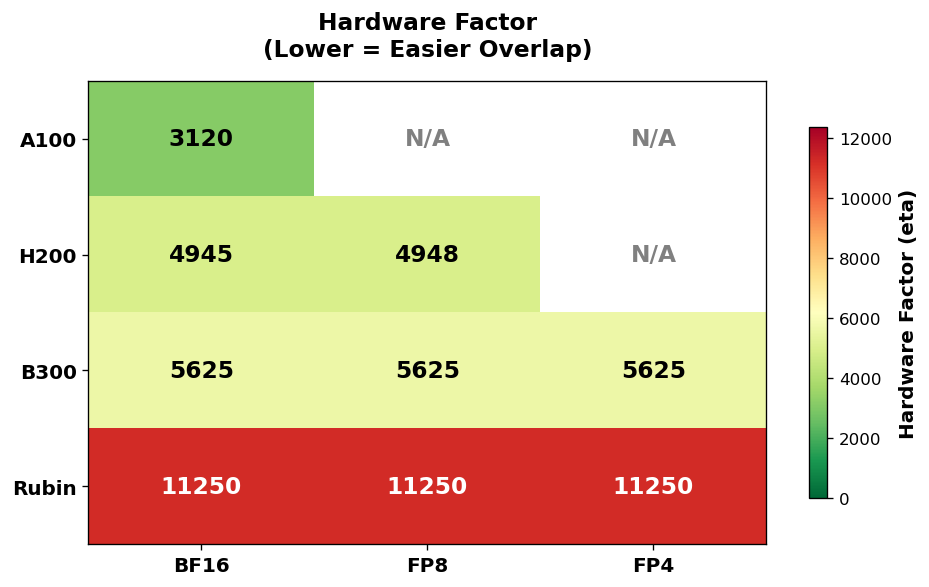

In [4]:
# =============================================================================
# HARDWARE FACTOR TABLE
# =============================================================================

def plot_hw_factor_table():
    """Heatmap of hardware factors (eta) for all GPU x dtype combinations."""
    gpus = list(GPUS.keys())
    dtypes = ["bf16", "fp8", "fp4"]
    
    # Build matrix
    data = np.zeros((len(gpus), len(dtypes)))
    for i, gpu_name in enumerate(gpus):
        gpu = GPUS[gpu_name]
        for j, dtype in enumerate(dtypes):
            try:
                data[i, j] = gpu.hw_factor(dtype)
            except ValueError:
                data[i, j] = np.nan
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
    
    # Custom colormap (lower = better = green)
    im = ax.imshow(data, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=np.nanmax(data)*1.1)
    
    # Labels
    ax.set_xticks(range(len(dtypes)))
    ax.set_yticks(range(len(gpus)))
    ax.set_xticklabels([d.upper() for d in dtypes], fontsize=12, fontweight='bold')
    ax.set_yticklabels(gpus, fontsize=12, fontweight='bold')
    
    # Add values in cells
    for i in range(len(gpus)):
        for j in range(len(dtypes)):
            val = data[i, j]
            if np.isnan(val):
                text = "N/A"
                color = 'gray'
            else:
                text = f"{val:.0f}"
                color = 'white' if val > np.nanmax(data)*0.5 else 'black'
            ax.text(j, i, text, ha='center', va='center', fontsize=14, 
                    fontweight='bold', color=color)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Hardware Factor (eta)', fontsize=12, fontweight='bold')
    
    ax.set_title('Hardware Factor\n(Lower = Easier Overlap)',
                 fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    return fig


# Print table
print("Hardware Factor (eta = TFLOPS x bytes / BW)")
print("=" * 50)
print(f"{'GPU':<10} {'BF16':>12} {'FP8':>12} {'FP4':>12}")
print("-" * 50)
for name, gpu in GPUS.items():
    row = [f"{name:<10}"]
    for dtype in ["bf16", "fp8", "fp4"]:
        try:
            eta = gpu.hw_factor(dtype)
            row.append(f"{eta:>12,.0f}")
        except ValueError:
            row.append(f"{'N/A':>12}")
    print("".join(row))
print()
print("Lower eta = easier to achieve overlap")

fig = plot_hw_factor_table()
plt.show()

---

# Case Study: DeepSeek V3

DeepSeek V3 has a critical **density mismatch** between layer types:

| Layer Type | Params | FLOPs @4K (fwd) | Density (rho) |
|------------|--------|-----------------|---------------|
| Dense Layer | 583M | 1.5B | **2.6** |
| MoE Layer | 11.5B | 1.5B | **0.13** |

**20x density gap** due to MoE sparsity (8/256 experts activated).

But attention FLOPs scale with sequence length, which helps!

In [5]:
# =============================================================================
# DEEPSEEK V3 CONFIGURATION
# =============================================================================

@dataclass
class DeepSeekV3Config:
    """DeepSeek V3 full config including MLA attention."""
    # FFN params
    hidden_size: int = 7168
    intermediate_size: int = 18432       # dense FFN
    moe_intermediate_size: int = 2048    # per-expert FFN
    n_routed_experts: int = 256
    num_experts_per_tok: int = 8
    n_shared_experts: int = 1
    num_hidden_layers: int = 61
    first_k_dense_replace: int = 3
    
    # MLA attention params
    num_attention_heads: int = 128
    q_lora_rank: int = 1536
    kv_lora_rank: int = 512
    qk_head_dim: int = 192        # = qk_nope + qk_rope
    qk_nope_head_dim: int = 128
    qk_rope_head_dim: int = 64
    v_head_dim: int = 128
    
    # Sparse attention (DSA/NSA)
    topk: int = 2048  # top-k tokens for sparse attention
    
    # NOTE: Forward pass only. Backward has ~2x compute and ~2x comm,
    # so B_crit ratio remains the same. See header for derivation.
    
    # ========== ATTENTION ==========
    @property
    def attn_params(self) -> int:
        """MLA attention params per layer."""
        h, H = self.hidden_size, self.num_attention_heads
        q_down = h * self.q_lora_rank
        q_up = self.q_lora_rank * H * self.qk_head_dim
        kv_a = h * (self.kv_lora_rank + self.qk_rope_head_dim)
        kv_b = self.kv_lora_rank * H * (self.qk_nope_head_dim + self.v_head_dim)
        o_proj = H * self.v_head_dim * h
        return q_down + q_up + kv_a + kv_b + o_proj
    
    def attn_flops_per_token(self, seq_len: int, sparse: bool = False) -> int:
        """
        MLA attention FLOPs per token (forward only).
        
        Args:
            seq_len: Sequence length
            sparse: If True, use top-k sparse attention (FLOPs capped at topk)
        """
        h, H = self.hidden_size, self.num_attention_heads
        
        # Projections (seq-independent): 2 FLOPs per multiply-add
        q_down_flops = 2 * h * self.q_lora_rank
        q_up_flops = 2 * self.q_lora_rank * H * self.qk_head_dim
        kv_a_flops = 2 * h * (self.kv_lora_rank + self.qk_rope_head_dim)
        kv_b_flops = 2 * self.kv_lora_rank * H * (self.qk_nope_head_dim + self.v_head_dim)
        o_proj_flops = 2 * H * self.v_head_dim * h
        proj_flops = q_down_flops + q_up_flops + kv_a_flops + kv_b_flops + o_proj_flops
        
        # QK and AV: O(seq_len) for dense, O(topk) for sparse
        effective_len = min(seq_len, self.topk) if sparse else seq_len
        qk_coef = 2 * H * self.qk_head_dim
        av_coef = 2 * H * self.v_head_dim
        attn_compute = (qk_coef + av_coef) * effective_len
        
        return proj_flops + attn_compute
    
    # ========== DENSE FFN ==========
    @property
    def dense_ffn_params(self) -> int:
        """Dense FFN params (SwiGLU: gate, up, down)."""
        return 3 * self.hidden_size * self.intermediate_size
    
    @property
    def dense_ffn_flops_per_token(self) -> int:
        """Dense FFN FLOPs per token (forward only)."""
        # SwiGLU: gate(h->i) + up(h->i) + down(i->h) = 3 matmuls, each 2*h*i FLOPs
        return 6 * self.hidden_size * self.intermediate_size
    
    # ========== MOE FFN ==========
    @property
    def moe_ffn_params(self) -> int:
        """MoE FFN params (ALL experts + router)."""
        router = self.hidden_size * self.n_routed_experts
        all_experts = (self.n_routed_experts + self.n_shared_experts) * 3 * self.hidden_size * self.moe_intermediate_size
        return router + all_experts
    
    @property
    def moe_ffn_flops_per_token(self) -> int:
        """MoE FFN FLOPs per token (forward only, only activated experts)."""
        router = 2 * self.hidden_size * self.n_routed_experts
        active_experts = self.num_experts_per_tok + self.n_shared_experts
        expert_flops = active_experts * 6 * self.hidden_size * self.moe_intermediate_size
        return router + expert_flops
    
    # ========== FULL LAYERS ==========
    @property
    def dense_layer_params(self) -> int:
        return self.attn_params + self.dense_ffn_params
    
    @property
    def moe_layer_params(self) -> int:
        return self.attn_params + self.moe_ffn_params
    
    def dense_layer_flops_per_token(self, seq_len: int, sparse: bool = False) -> int:
        return self.attn_flops_per_token(seq_len, sparse) + self.dense_ffn_flops_per_token
    
    def moe_layer_flops_per_token(self, seq_len: int, sparse: bool = False) -> int:
        return self.attn_flops_per_token(seq_len, sparse) + self.moe_ffn_flops_per_token
    
    # ========== DENSITY ==========
    def dense_layer_density(self, seq_len: int, sparse: bool = False) -> float:
        """Dense layer compute density (rho)."""
        return self.dense_layer_flops_per_token(seq_len, sparse) / self.dense_layer_params
    
    def moe_layer_density(self, seq_len: int, sparse: bool = False) -> float:
        """MoE layer compute density (rho)."""
        return self.moe_layer_flops_per_token(seq_len, sparse) / self.moe_layer_params


# Instantiate and print stats
cfg = DeepSeekV3Config()

print("DeepSeek V3 Per-Layer Statistics (Forward Pass Only)")
print("=" * 70)
print()
print("MLA Attention (per layer):")
print(f"  Params:                   {cfg.attn_params/1e6:>10.2f}M")
print(f"  FLOPs/token @4K (dense):  {cfg.attn_flops_per_token(4096, sparse=False)/1e9:>10.2f}B")
print(f"  FLOPs/token @128K (dense):{cfg.attn_flops_per_token(131072, sparse=False)/1e9:>10.2f}B")
print(f"  FLOPs/token @128K (sparse, topk={cfg.topk}): {cfg.attn_flops_per_token(131072, sparse=True)/1e9:>6.2f}B")
print()
print("MoE FFN:")
print(f"  Params (ALL):             {cfg.moe_ffn_params/1e9:>10.2f}B")
print(f"  FLOPs/token:              {cfg.moe_ffn_flops_per_token/1e9:>10.2f}B (9/257 experts)")
print()
print("-" * 70)
print("FULL MoE LAYER (Attn + MoE FFN):")
print("-" * 70)
print()
print(f"{'Attention':<12} {'seq_len':<10} {'FLOPs':>12} {'Density':>12}")
print(f"{'Dense':<12} {'4K':<10} {cfg.moe_layer_flops_per_token(4096, sparse=False)/1e9:>11.2f}B {cfg.moe_layer_density(4096, sparse=False):>12.3f}")
print(f"{'Dense':<12} {'128K':<10} {cfg.moe_layer_flops_per_token(131072, sparse=False)/1e9:>11.2f}B {cfg.moe_layer_density(131072, sparse=False):>12.3f}")
print(f"{'Sparse':<12} {'128K':<10} {cfg.moe_layer_flops_per_token(131072, sparse=True)/1e9:>11.2f}B {cfg.moe_layer_density(131072, sparse=True):>12.3f}")
print()
print(f"Sparse attention caps FLOPs at topk={cfg.topk}, eliminating long-sequence benefit!")

DeepSeek V3 Per-Layer Statistics (Forward Pass Only)

MLA Attention (per layer):
  Params:                       187.11M
  FLOPs/token @4K (dense):        0.71B
  FLOPs/token @128K (dense):     11.11B
  FLOPs/token @128K (sparse, topk=2048):   0.54B

MoE FFN:
  Params (ALL):                  11.32B
  FLOPs/token:                    0.80B (9/257 experts)

----------------------------------------------------------------------
FULL MoE LAYER (Attn + MoE FFN):
----------------------------------------------------------------------

Attention    seq_len           FLOPs      Density
Dense        4K                1.51B        0.131
Dense        128K             11.91B        1.035
Sparse       128K              1.34B        0.116

Sparse attention caps FLOPs at topk=2048, eliminating long-sequence benefit!


Compute Density Comparison: Dense Layer vs MoE Layer
seq_len    |    Dense Layer |    MoE (dense) |   MoE (sparse) |  Gap (D/MoE_s)
------------------------------------------------------------------------------------------
4K         |          2.575 |          0.131 |          0.116 |          22.1x
8K         |          3.150 |          0.160 |          0.116 |          27.1x
16K         |          4.300 |          0.218 |          0.116 |          37.0x
32K         |          6.601 |          0.335 |          0.116 |          56.8x
64K         |         11.201 |          0.568 |          0.116 |          96.3x
128K         |         20.403 |          1.035 |          0.116 |         175.4x

Dense Layer has much higher density due to:
  - Dense FFN: ALL params used (vs MoE's 8/256 = 3%)
  - Same attention FLOPs, but much fewer total params


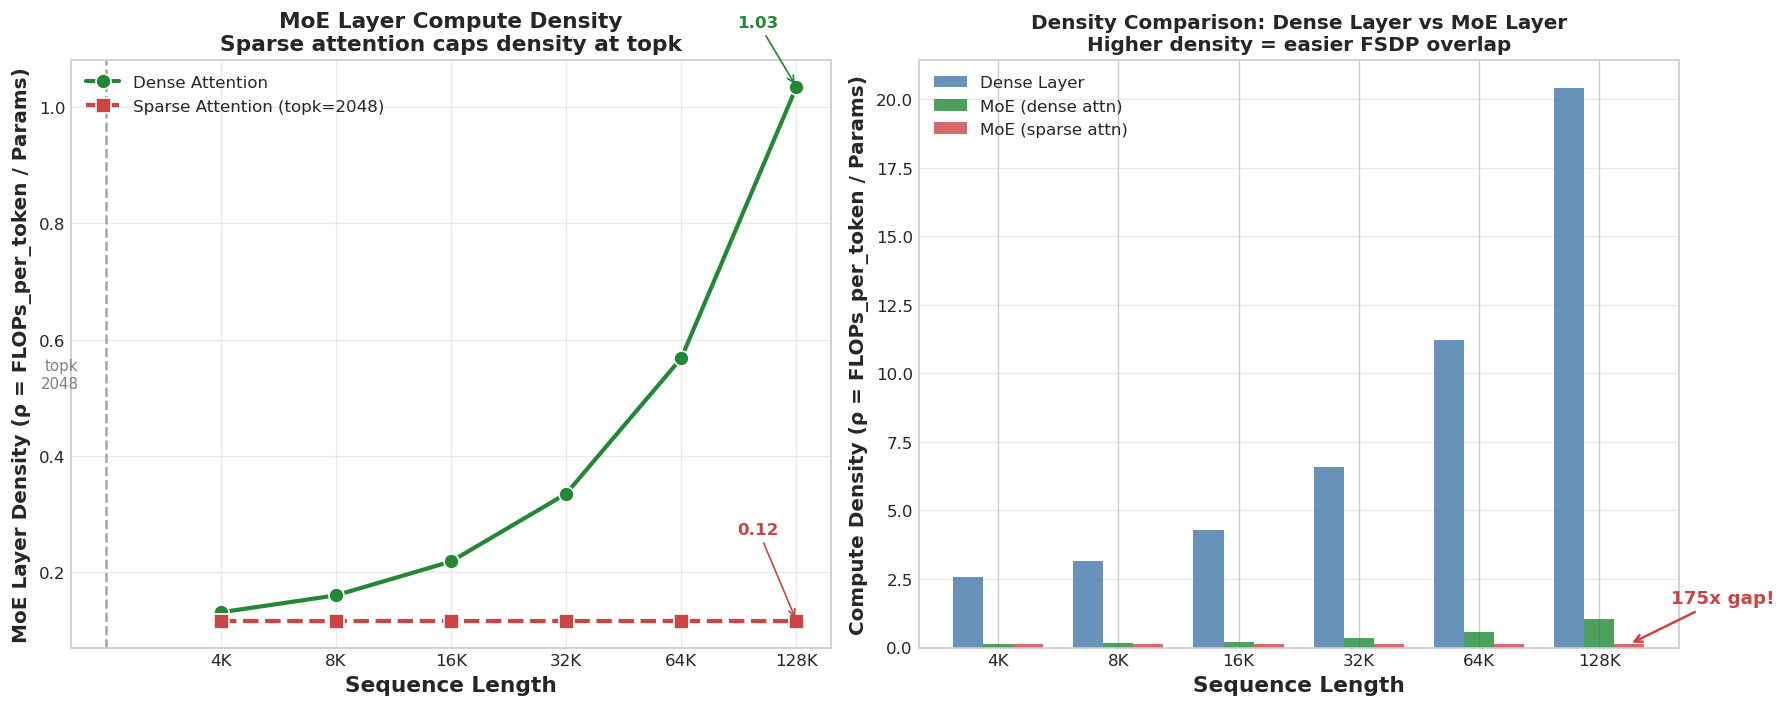

In [6]:
# =============================================================================
# DENSITY ANALYSIS: How density changes with sequence length
# =============================================================================

def plot_density_analysis():
    """
    Show how FLOPs_per_token / Params (compute density) changes with seq_len.
    Left: MoE layer density curves. Right: Density comparison (Dense vs MoE).
    """
    seq_lens = np.array([4096, 8192, 16384, 32768, 65536, 131072])
    cfg = DeepSeekV3Config()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=120)
    
    # ===== Left plot: MoE Layer Density (rho) vs seq_len =====
    # Dense attention
    moe_density_dense = [cfg.moe_layer_density(s, sparse=False) for s in seq_lens]
    # Sparse attention (topk=2048)
    moe_density_sparse = [cfg.moe_layer_density(s, sparse=True) for s in seq_lens]
    
    # Plot MoE layer density only (cleaner)
    ax1.plot(seq_lens, moe_density_dense, 'o-', lw=2.5, ms=9, color='#228833', 
             label='Dense Attention', markeredgecolor='white', markeredgewidth=1)
    ax1.plot(seq_lens, moe_density_sparse, 's--', lw=2.5, ms=9, color='#CC4444',
             label=f'Sparse Attention (topk={cfg.topk})', markeredgecolor='white', markeredgewidth=1)
    
    def format_k(x, pos):
        return f'{x/1024:.0f}K'
    
    ax1.set_xlabel('Sequence Length', fontsize=13, fontweight='600')
    ax1.set_ylabel('MoE Layer Density (ρ = FLOPs_per_token / Params)', fontsize=12, fontweight='600')
    ax1.set_xscale('log', base=2)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_k))
    ax1.set_xticks(seq_lens)
    ax1.legend(fontsize=10, loc='upper left')
    ax1.grid(True, alpha=0.4)
    ax1.set_title('MoE Layer Compute Density\nSparse attention caps density at topk',
                  fontsize=13, fontweight='bold')
    
    # Vertical line at topk
    ax1.axvline(x=cfg.topk, color='gray', ls='--', lw=1.5, alpha=0.7)
    ax1.text(cfg.topk * 0.85, ax1.get_ylim()[1] * 0.5, f'topk\n{cfg.topk}', 
             fontsize=9, color='gray', ha='right', va='center')
    
    # Annotations - position them better
    ax1.annotate(f'{moe_density_dense[-1]:.2f}', 
                 xy=(seq_lens[-1], moe_density_dense[-1]),
                 xytext=(seq_lens[-1]*0.7, moe_density_dense[-1]*1.1), fontsize=10,
                 color='#228833', fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='#228833', lw=1))
    ax1.annotate(f'{moe_density_sparse[-1]:.2f}', 
                 xy=(seq_lens[-1], moe_density_sparse[-1]),
                 xytext=(seq_lens[-1]*0.7, moe_density_sparse[-1]+0.15), fontsize=10,
                 color='#CC4444', fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='#CC4444', lw=1))
    
    # ===== Right plot: Density comparison - Dense Layer vs MoE =====
    # Compute densities for all three layer types
    dense_layer_density = [cfg.dense_layer_density(s, sparse=False) for s in seq_lens]
    moe_dense_density = [cfg.moe_layer_density(s, sparse=False) for s in seq_lens]
    moe_sparse_density = [cfg.moe_layer_density(s, sparse=True) for s in seq_lens]

    width = 0.25
    x = np.arange(len(seq_lens))

    # Three groups of bars
    ax2.bar(x - width, dense_layer_density, width, label='Dense Layer', color='#4477AA', alpha=0.8)
    ax2.bar(x, moe_dense_density, width, label='MoE (dense attn)', color='#228833', alpha=0.8)
    ax2.bar(x + width, moe_sparse_density, width, label='MoE (sparse attn)', color='#CC4444', alpha=0.8)

    ax2.set_xlabel('Sequence Length', fontsize=13, fontweight='600')
    ax2.set_ylabel('Compute Density (ρ = FLOPs_per_token / Params)', fontsize=12, fontweight='600')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{s//1024}K' for s in seq_lens])
    ax2.legend(fontsize=10, loc='upper left')
    ax2.grid(True, alpha=0.4, axis='y')
    ax2.set_title('Density Comparison: Dense Layer vs MoE Layer\nHigher density = easier FSDP overlap',
                  fontsize=12, fontweight='bold')
    
    # Add density gap annotation at 128K
    gap = dense_layer_density[-1] / moe_sparse_density[-1]
    ax2.annotate(f'{gap:.0f}x gap!', 
                 xy=(x[-1] + width, moe_sparse_density[-1]),
                 xytext=(x[-1] + 0.6, moe_sparse_density[-1] + 1.5),
                 fontsize=11, color='#CC4444', fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='#CC4444', lw=1.5))
    
    plt.tight_layout()
    return fig


# Print density table
print("Compute Density Comparison: Dense Layer vs MoE Layer")
print("=" * 90)
print(f"{'seq_len':<10} | {'Dense Layer':>14} | {'MoE (dense)':>14} | {'MoE (sparse)':>14} | {'Gap (D/MoE_s)':>14}")
print("-" * 90)
cfg = DeepSeekV3Config()
for s in [4096, 8192, 16384, 32768, 65536, 131072]:
    d_dense_layer = cfg.dense_layer_density(s, sparse=False)
    d_moe_dense = cfg.moe_layer_density(s, sparse=False)
    d_moe_sparse = cfg.moe_layer_density(s, sparse=True)
    gap = d_dense_layer / d_moe_sparse
    print(f"{s//1024}K{'':<8} | {d_dense_layer:>14.3f} | {d_moe_dense:>14.3f} | {d_moe_sparse:>14.3f} | {gap:>13.1f}x")
print()
print("Dense Layer has much higher density due to:")
print("  - Dense FFN: ALL params used (vs MoE's 8/256 = 3%)")
print("  - Same attention FLOPs, but much fewer total params")

fig = plot_density_analysis()
plt.show()

B_crit = eta / rho (MoE Layer)

=== Dense Attention ===
GPU      dtype  |       4K |       8K |      16K |      32K |      64K |     128K
---------------------------------------------------------------------------
A100     bf16   |   23837 |   19494 |   14288 |    9313 |    5490 |    3015
H200     bf16   |   37781 |   30897 |   22646 |   14761 |    8702 |    4779
H200     fp8    |   37800 |   30913 |   22657 |   14769 |    8706 |    4781
B300     bf16   |   42976 |   35146 |   25760 |   16791 |    9898 |    5436
B300     fp8    |   42976 |   35146 |   25760 |   16791 |    9898 |    5436
B300     fp4    |   42976 |   35146 |   25760 |   16791 |    9898 |    5436
Rubin    bf16   |   85952 |   70292 |   51519 |   33582 |   19797 |   10871
Rubin    fp8    |   85952 |   70292 |   51519 |   33582 |   19797 |   10871
Rubin    fp4    |   85952 |   70292 |   51519 |   33582 |   19797 |   10871

=== Sparse Attention (topk=2048) ===
GPU      dtype  |       4K |       8K |      16K |      32K |   

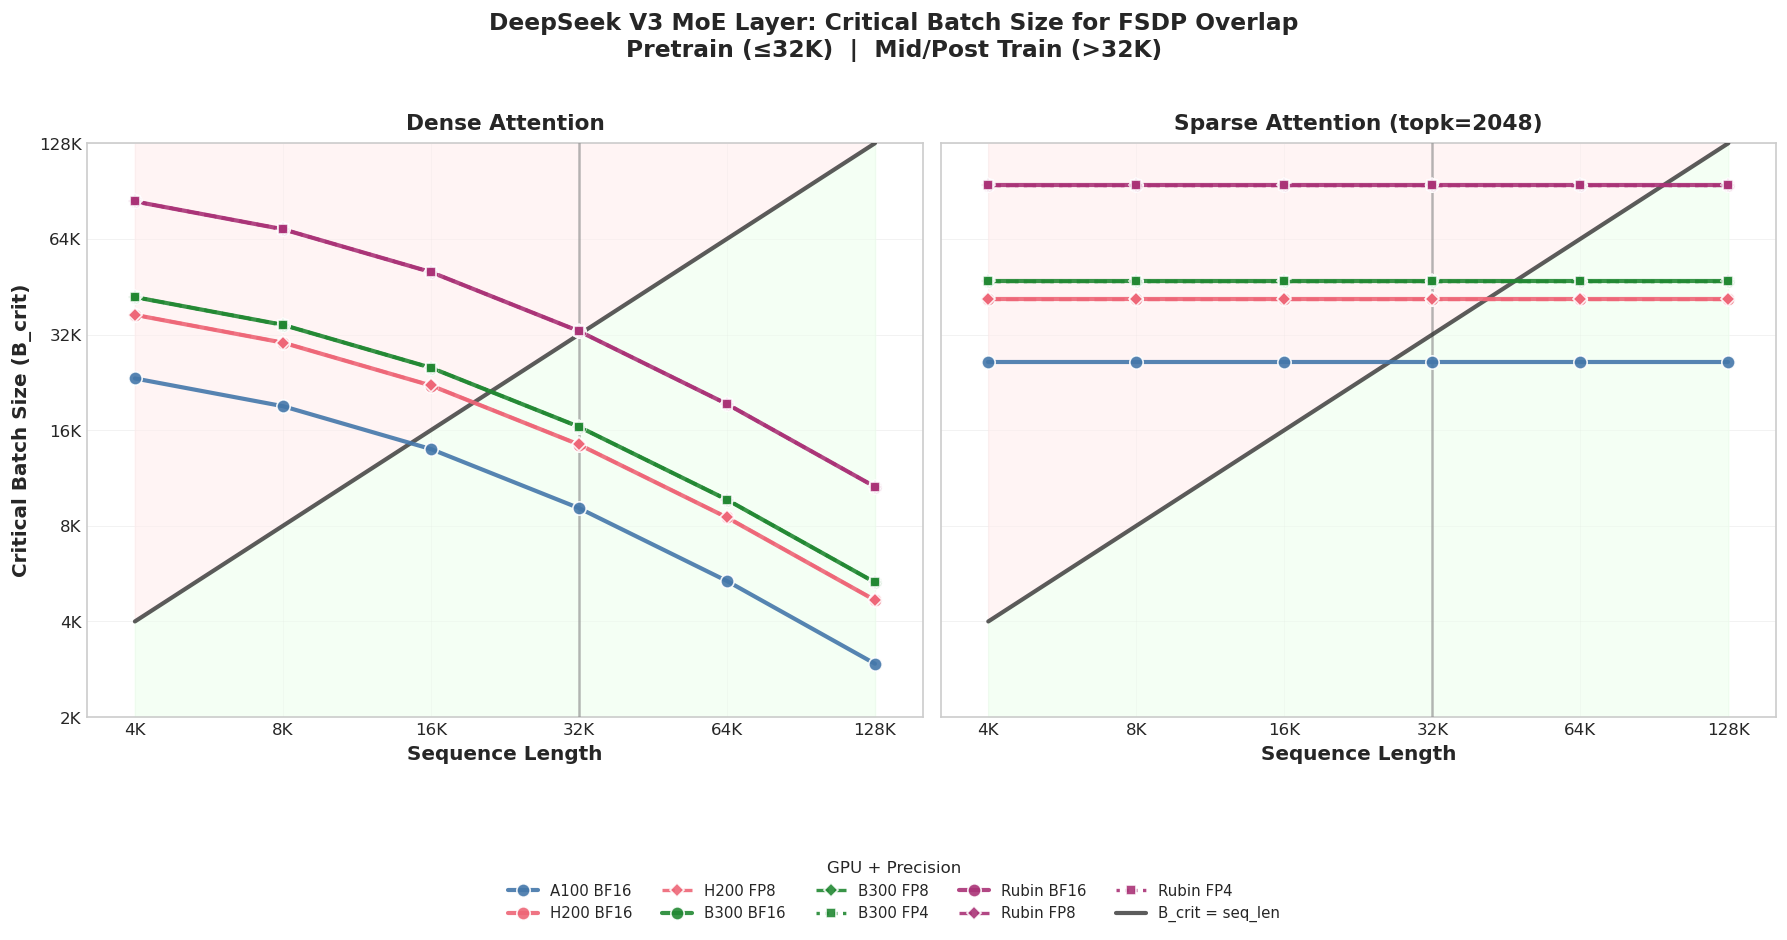

In [7]:
# =============================================================================
# B_CRIT ANALYSIS: Main Result
# =============================================================================

def compute_bcrit_moe(seq_len: int, gpu_name: str, dtype: str, sparse: bool = False) -> float:
    """
    Compute B_crit for MoE layer using our core formula:
    B_crit = eta / rho = hw_factor / density
    """
    gpu = GPUS[gpu_name]
    cfg = DeepSeekV3Config()
    
    eta = gpu.hw_factor(dtype)
    rho = cfg.moe_layer_density(seq_len, sparse=sparse)
    
    return bcrit(rho, eta)


def plot_bcrit_analysis():
    """
    MoE layer B_crit: Left = Dense, Right = Sparse (topk=2048)
    """
    seq_lens = np.array([4096, 8192, 16384, 32768, 65536, 131072])
    cfg = DeepSeekV3Config()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=120, sharey=True)

    # Color and style mapping
    gpu_colors = {
        "A100": "#4477AA",
        "H200": "#EE6677",
        "B300": "#228833",
        "Rubin": "#AA3377",
    }
    dtype_styles = {
        "bf16": ("-", "o", 2.5, 8),
        "fp8":  ("--", "D", 2.0, 6),
        "fp4":  (":", "s", 2.0, 6),
    }

    configs = [
        ("A100", "bf16"),
        ("H200", "bf16"), ("H200", "fp8"),
        ("B300", "bf16"), ("B300", "fp8"), ("B300", "fp4"),
        ("Rubin", "bf16"), ("Rubin", "fp8"), ("Rubin", "fp4"),
    ]

    def format_k(x, pos):
        return f'{x/1024:.0f}K'

    y_min, y_max = 2048, 131072
    phase_boundary = 32768

    for ax, sparse, title in [(ax1, False, 'Dense Attention'), (ax2, True, f'Sparse Attention (topk={cfg.topk})')]:
        for gpu_name, dtype in configs:
            try:
                ls, marker, lw, ms = dtype_styles[dtype]
                b_crits = [compute_bcrit_moe(s, gpu_name, dtype, sparse=sparse) for s in seq_lens]
                ax.plot(seq_lens, b_crits, ls=ls, marker=marker, lw=lw, ms=ms,
                        color=gpu_colors[gpu_name], label=f'{gpu_name} {dtype.upper()}',
                        markeredgecolor='white', markeredgewidth=1, alpha=0.9, zorder=10)
            except ValueError:
                continue

        # Diagonal
        ax.plot(seq_lens, seq_lens, color='#333333', lw=2.5, ls='-',
                label='B_crit = seq_len', alpha=0.8, zorder=5)

        # Shade regions (more subtle)
        ax.fill_between(seq_lens, seq_lens, y_max * 2, color='#FFEEEE', alpha=0.6, zorder=1)
        ax.fill_between(seq_lens, y_min / 2, seq_lens, color='#EEFFEE', alpha=0.6, zorder=1)

        # Training phase boundary - simple vertical line
        ax.axvline(x=phase_boundary, color='#888888', ls='-', lw=1.5, alpha=0.6, zorder=3)

        # Formatting
        ax.set_xlabel('Sequence Length', fontsize=12, fontweight='600')
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_k))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(format_k))
        ax.set_xticks(seq_lens)
        ax.set_yticks([2048, 4096, 8192, 16384, 32768, 65536, 131072])
        ax.set_xlim(seq_lens[0] * 0.8, seq_lens[-1] * 1.25)
        ax.set_ylim(y_min, y_max)
        ax.set_title(title, fontsize=13, fontweight='bold', pad=8)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)

    ax1.set_ylabel('Critical Batch Size (B_crit)', fontsize=12, fontweight='600')

    # Legend below the plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.08),
               ncol=5, fontsize=9, title='GPU + Precision', title_fontsize=10,
               framealpha=0.95, edgecolor='#CCCCCC')

    # Main title with training phase annotation
    fig.suptitle('DeepSeek V3 MoE Layer: Critical Batch Size for FSDP Overlap\n'
                 'Pretrain (≤32K)  |  Mid/Post Train (>32K)',
                 fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18)
    return fig


# Print B_crit table
print("B_crit = eta / rho (MoE Layer)")
print()
cfg = DeepSeekV3Config()

for sparse, attn_type in [(False, "Dense Attention"), (True, f"Sparse Attention (topk={cfg.topk})")]:
    print(f"=== {attn_type} ===")
    print(f"{'GPU':<8} {'dtype':<6} | {'4K':>8} | {'8K':>8} | {'16K':>8} | {'32K':>8} | {'64K':>8} | {'128K':>8}")
    print("-" * 75)
    for gpu_name in GPUS:
        for dtype in ["bf16", "fp8", "fp4"]:
            try:
                b_crits = [compute_bcrit_moe(s, gpu_name, dtype, sparse=sparse) 
                          for s in [4096, 8192, 16384, 32768, 65536, 131072]]
                print(f"{gpu_name:<8} {dtype:<6} | " + " | ".join([f"{b:>7.0f}" for b in b_crits]))
            except ValueError:
                continue
    print()

fig = plot_bcrit_analysis()
plt.show()

---

# Key Insights

## 1. Density is THE Model Design Metric

$$\rho = \frac{\text{FLOPs}_{\text{per token}}}{\text{Params}}$$

- MoE's k/E ratio directly determines density
- **More active experts -> higher ρ -> easier overlap**
- DeepSeek V3 uses 8/256 = 3% -> very low density!

## 2. Long Sequences Help MoE (Dense Attention Only!)

With **dense attention**, FLOPs_per_token scale with O(seq_len):

| seq_len | MoE Density | Improvement |
|---------|-------------|-------------|
| 4K | 0.13 | 1x (baseline) |
| 16K | 0.22 | 1.7x |
| 64K | 0.57 | 4.3x |
| 128K | 1.04 | **7.9x** |

## 3. Sparse Attention Eliminates Long-Sequence Benefit

With **sparse attention (topk=2048)**, FLOPs_per_token are capped:

| seq_len | Dense ρ | Sparse ρ | Loss |
|---------|---------|----------|------|
| 4K | 0.13 | 0.12 | 11% |
| 16K | 0.22 | 0.12 | 47% |
| 64K | 0.57 | 0.12 | 80% |
| 128K | 1.04 | 0.12 | **89%** |

**Critical insight**: Sparse attention trades compute efficiency for harder FSDP overlap!

## 4. Hardware Evolution

The hardware factor $\eta = \frac{\text{TFLOPS} \times \text{bytes}}{\text{BW}}$:

- If BW grows faster than TFLOPS -> η decreases -> easier overlap
- But MoE's **~20x density gap** remains the fundamental bottleneck
- **Sparse attention makes it even worse** by removing the seq_len scaling

## 5. The Constraint: batch_size >= seq_len

You need at least 1 sequence per batch:
- If B_crit < seq_len: **Single sequence is enough** for overlap
- If B_crit > seq_len: **Need multiple sequences** for overlap

With sparse attention, B_crit stays high even at long sequences!

---

## Summary Formula

$$\boxed{B_{crit} = \frac{\eta}{\rho} = \frac{\text{TFLOPS} \times \text{bytes}}{\text{BW}} \times \frac{\text{Params}}{\text{FLOPs}_{\text{per token}}}}$$

**Design implications:**
- **Model designer**: Maximize ρ (higher k/E ratio, avoid sparse attention if overlap matters)
- **Hardware vendor**: Minimize η (more bandwidth relative to compute)
- **System designer**: With sparse attention, expect harder overlap at long sequences